
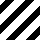
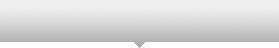
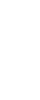
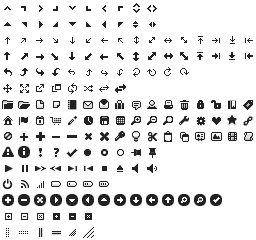
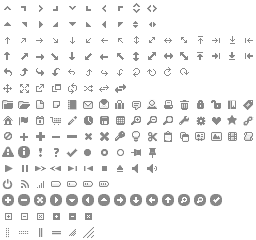
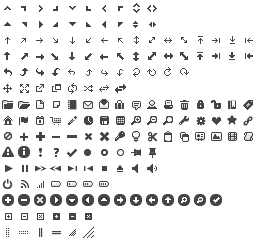
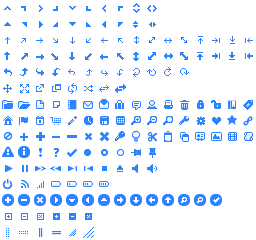
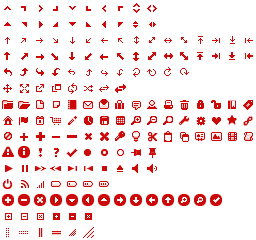
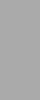
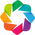
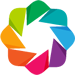
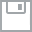
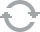
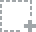
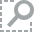
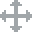
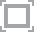
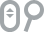

In [1]:
from __future__ import division
import glob
from datetime import datetime, timedelta
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pandas as pd

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()
from castra import Castra

from mpl_toolkits.basemap import Basemap

from bokeh.plotting import figure, show, output_notebook
output_notebook()

import statsmodels.api as sm

import seaborn as sns

%matplotlib inline

In [2]:
date_parser = lambda x: datetime.strptime(x, '%Y%m%d')

CATEGORIES = ['Station', 'Komponente','TYPE_OF_AREA', 'TYPE_OF_STATION', 'TYPE_OF_DATA', 'Lieferung']
ID_VARS = list(CATEGORIES) + ['Datum']
VALUES = ['Wert{:02d}'.format(i) for i in range(1, 25)]

date_format = "%Y%m%d %H"

def create_dataframe():
    df = dd.read_csv('data/DE*.csv', encoding='latin1', sep=';', quotechar="'", na_values=['', '-999', '-111'],
                     parse_dates=['Datum'], date_parser=date_parser, index_col=False)

    df = df.compute()
    print('Make categories...')
    for c in CATEGORIES:
        df[c] = df[c].astype('category')

    print('Melting values...')
    df = pd.melt(df, id_vars=ID_VARS, value_vars=VALUES, var_name='hour', value_name='value')
    print('Converting hour column...')
    hours = df.hour.map(lambda x: x[4:]).convert_objects(convert_numeric=True) - 1
    hours = pd.to_timedelta(hours, unit='h')
    print('Applying hour to date column...')
    df['date'] = df.Datum + hours
    df = df.drop(['Datum', 'hour'], axis=1)
    print('Setting index...')
    df = df.set_index('date')
    return df

def get_daskframe(path='stickoxide.castra'):
    if not os.path.exists(path):
        print('Castra path "%s" not found, recreating...' % path)
        df = create_dataframe()
        print('Writing castra file...')
        c = Castra(path, template=df, categories=True)
        c.extend(df)
        return c.to_dask()
    c = Castra(path=path)
    return c.to_dask()

dfk = get_daskframe()
df = dfk.compute()
df.head()

[########################################] | 100% Completed |  1.3s


,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value
date,,,,,,,
2009-01-01,DEBB007,Stickstoffdioxid,vorstädtisches Gebiet,Hintergrund,H,Y,23.20
2009-01-01,DERP010,Stickstoffdioxid,städtisches Gebiet,Verkehr,H,Y,49.50
2009-01-01,DERP009,Stickstoffdioxid,städtisches Gebiet,Hintergrund,H,Y,41.70
2009-01-01,DERP008,Stickstoffdioxid,städtisches Gebiet,Hintergrund,H,Y,42.70
2009-01-01,DERP007,Stickstoffdioxid,städtisches Gebiet,Hintergrund,H,Y,41.05


In [3]:
german_date_parser = lambda x: datetime.strptime(x, '%d.%m.%Y')
stations = pd.read_csv('data/station_All.csv', encoding='latin1', sep=';', quotechar='"', skiprows=1, parse_dates=[4, 5], date_parser=german_date_parser)
stations[u'Aktivitätsperiode: bis'] = stations[u'Aktivitätsperiode: bis'].convert_objects(convert_dates='coerce')
stations[u'lng'] = stations[u'Länge dezimal'].str.replace(',', '.').convert_objects(convert_numeric=True)
stations[u'lat'] = stations[u'Breite dezimal'].str.replace(',', '.').convert_objects(convert_numeric=True)
stations['height'] = stations[u'Höhe'].convert_objects(convert_numeric=True)
stations['ags'] = stations[u'Amtlicher Gemeindeschlüssel (AGS)'].dropna().apply(lambda x: '{:0>5d}'.format(int(str(x)[:5])))
stations = stations.rename(columns={'Stationscode': 'Station'})
stations.head()

,Station,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,Nr,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
0,DEBB001,Burg (Spreewald),Luftmessstation,BUCH,1993-01-01,1993-01-01,2003-05-19,nein,Bahnhofstr.,9,...,no,"3,5","3,5",NaN,k.A.,NaN,14.141703,51.837590,54,12071
1,DEBB002,Brandenburg-Nord,Luftmessstation,BRGU,1991-02-01,1991-02-01,1994-06-30,nein,GutsMuthsstraße,NaN,...,no,"3,5",NaN,NaN,k.A.,NaN,12.560379,52.420960,31,12051
2,DEBB003,Brandenburg a.d. Havel,Luftmessstation,BRPI,1991-03-01,1991-03-01,2001-07-06,nein,Gertrud-Pieter-Platz,9,...,1A3,"3,5","3,5",NaN,k.A.,NaN,12.544441,52.412114,33,12051
3,DEBB004,Cottbus-LUA,Luftmessstation,COUA,1991-01-01,1991-01-01,2003-12-31,nein,Am Nordrand,45,...,no,"3,5",NaN,NaN,k.A.,NaN,14.327692,51.778045,68,12052
4,DEBB005,Cottbus-City (-Mitte),Luftmessstation,COCY,1991-01-01,1991-01-01,1997-03-31,nein,Karl-Liebknecht-Str.,136,...,no,"3,5","3,5",NaN,k.A.,NaN,14.331685,51.757900,74,12052


In [4]:
bbox = {
  'lon': 10.45415,
  'lat': 51.164181,
  'll_lon': 5.86624,
  'll_lat': 47.27021,
  'ur_lon': 15.04205,
  'ur_lat': 55.05814
}

def shifted_color_map(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def plot_map(df, vals='value', cmap='cool', diverging=False):
    if diverging:
        vmin = df[vals].min()
        vmax = df[vals].max()
        midrange = 1 - vmax / (vmax + abs(vmin))
        cmap = shifted_color_map(matplotlib.cm.get_cmap(cmap), midpoint=midrange)
        
    markersize = 40
    markertype = 'o'  # pixel
    markercolor = '#325CA9'  # blue
    if vals is not None:
        markercolor = df[vals].as_matrix()
    markeralpha = .75 #  a bit of transparency

    fig = plt.figure(figsize=(10,16))
    m = Basemap(
      projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
      llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
      urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'],
      resolution='l'
    )
    m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
    x, y = m(df.lng.as_matrix(), df.lat.as_matrix())
    m.drawcoastlines()
    m.drawcountries()
    m.scatter(x, y, markersize, marker=markertype,  cmap=cmap, c=markercolor, alpha=markeralpha)
    m.colorbar()
    return m


In [5]:
df.Komponente.value_counts()

Stickstoffdioxid    24690024
dtype: int64

In [6]:
df.TYPE_OF_AREA.value_counts()

städtisches Gebiet       14713392
vorstädtisches Gebiet     5046072
ländliches Gebiet         2017080
ländlich regional         1600992
ländlich stadtnah          943920
ländlich abgelegen         368568
dtype: int64

In [7]:
df.TYPE_OF_STATION.value_counts()

Hintergrund    14944800
Verkehr         8298312
Industrie       1446912
dtype: int64

In [8]:
df.TYPE_OF_DATA.value_counts()

# S = Stundendaten
# H = Halbstündlich
# T = Tagesdaten

S    16223640
H     8203440
T      262944
dtype: int64

## Map of all stations coloured by their median measurement 2015

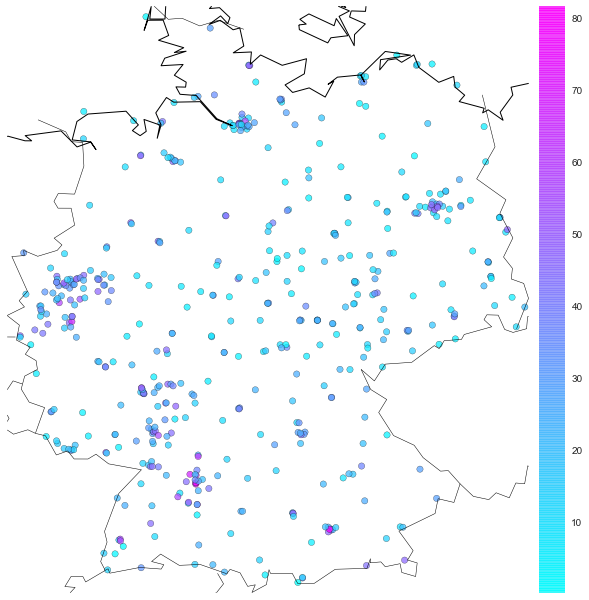

In [9]:
filtered = df[df.index.year == 2015]
filtered = filtered.groupby('Station')
filtered = filtered.value.median().reset_index()
filtered = filtered.merge(stations, on='Station')
plot_map(filtered, 'value')

## All stations with their 2015 median value greater than 50.

That means that half of all measurements in 2015 were greater than 50!

In [10]:
filtered[filtered.value > 50]

,Station,value,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
1,DERP010,54.578995,Mainz-Parcusstraße,Luftmessstation,NaN,1979-01-01,1979-01-01,NaT,nein,Parcusstraße/Bahnhofstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.261277,50.000973,85,73150
18,DENW211,66.776500,Köln Clevischer Ring 3,Luftmessstation,NaN,2006-05-06,2006-05-06,NaT,NaN,Clevischer Ring,...,1A3,"3,5","3,5",NaN,k.A.,NaN,7.004590,50.962857,48,53150
20,DENW189,52.064000,Wuppertal Gathe,Luftmessstation,NaN,2005-06-30,2005-06-30,NaT,NaN,Gathe,...,1A3,"3,5","3,5",NaN,k.A.,NaN,7.147401,51.260681,160,51240
34,DERP042,53.620436,Pirmasens Schäferstr.,Luftmessstation,NaN,2002-03-25,2002-03-25,2014-08-12,nein,Schäferstr./Kaffeegasse,...,no,"3,5","3,5",NaN,k.A.,NaN,7.603053,49.199942,361,73170
86,DENW102,52.921500,Duisburg-Bruckhausen,Luftmessstation,DUBR,1996-09-02,1996-09-02,2013-12-31,NaN,Kaiser-Wilhelm-Str.,...,2,"3,5","3,5",NaN,k.A.,NaN,6.735854,51.485847,28,51120
91,DENW082,57.943000,Düsseldorf Corneliusstraße,Luftmessstation,DDCS,1997-03-13,1997-03-13,NaT,ja,Corneliusstr.,...,1A3,"3,5","3,5",NaN,k.A.,NaN,6.782565,51.213110,37,51110
218,DEBW116,73.000000,Stuttgart Hohenheimer Straße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Hohenheimer Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.184490,48.768710,302,81110
224,DEBW099,60.000000,Stuttgart_Arnulf-Klett-Platz,Luftmessstation,NaN,1994-12-06,1994-12-06,NaT,nein,Arnulf-Klett-Platz,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.180720,48.783130,244,81110
229,DEBW117,58.000000,Ludwigsburg Friedrichstraße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Friedrichstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.190030,48.889200,299,81180
244,DEBW118,80.000000,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Am Neckartor,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110


## Top 20 highest measurements in dataset

"DENW116" (Krefeld (Hafen), Luftmessstation, Geo: 51.342561, 6.670195):

A fire seems to be the cause:
http://feuerwehr-herscheid.de/eins%C3%A4tze/2012/krefeld-26-09-12/
https://www.derwesten.de/staedte/duisburg/loescharbeiten-in-duengemittelfabrik-werden-noch-tage-dauern-id7135294.html
https://www.derwesten.de/staedte/nachrichten-aus-wesel-hamminkeln-und-schermbeck/-id7133204.html

Despite reports, the values indicate that air pollution was at unhealthy levels!

Site of fire and site of detector:
https://www.bing.com/maps/#Y3A9NTEuMDAwMDAwfjkuMDAwMDAwJmx2bD01JnN0eT1yJndoZXJlMT01MSVDMiVCMDIwJzMzLjIlMjJOJTIwNiVDMiVCMDQwJzEyLjclMjJF


In [11]:
df.sort_index(by='value', ascending=False).head(20)

,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value
date,,,,,,,
2012-09-26 00:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1346.706000
2012-09-26 05:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1294.062000
2012-09-25 23:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1275.116000
2012-09-26 01:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1206.955000
2012-09-26 03:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1088.394000
2012-09-26 04:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,987.990000
2012-09-26 06:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,985.045000
2012-09-27 02:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,900.788000
2012-09-25 21:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,879.932000


In [12]:
stations[stations.Station == 'DEBW099']

,Station,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,Nr,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
257,DEBW099,Stuttgart_Arnulf-Klett-Platz,Luftmessstation,NaN,1994-12-06,1994-12-06,NaT,nein,Arnulf-Klett-Platz,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.18072,48.78313,244,81110


## Cross-checking

[This report](http://www.umweltbundesamt.de/sites/default/files/medien/358/dokumente/no2_2014_0.pdf) contains Jahresmittelwert and number of occasions when Stundenmittelwerte exceeded 200. Cross-checking some values from the table.

In [13]:
filtered = df[(df.Station == 'DEBW152') & (df.index.year == 2014)]
filtered.value.mean()

65.087167070217916

In [14]:
filtered[filtered.value > 200]

,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value
date,,,,,,,
2014-11-03 08:00:00,DEBW152,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,Y,219


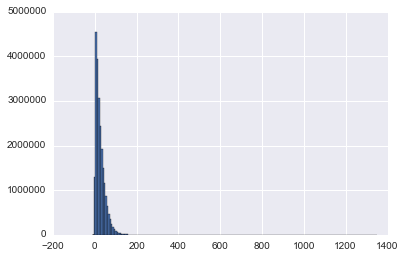

In [15]:
df.value.hist(bins=200)

TODO
 - Stacked Line Chart für Messstationen von Kreisen (Kreis)
 - Autobahnen, Schiffe, Heimöfen?

## Stationen mit mehr als 40 µg/m^3 in 2015

In [16]:
df_2015 = df[df.index.year == 2015]
mean_2015 = df_2015.groupby('Station').value.mean()
exceeding_40 = mean_2015[mean_2015 > 40].reset_index()
stations_exceeding_40 = exceeding_40.merge(stations, on='Station')
stations_exceeding_40.sort_index(by='value', ascending=False)

,Station,value,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
52,DEBY115,84.986500,München/Landshuter Allee,Luftmessstation,NaN,2004-07-01,2004-07-01,NaT,nein,Landshuter Allee,...,1A3,"3,9","4,5",NaN,k.A.,NaN,11.536513,48.149606,521,91620
26,DEBW118,84.889023,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Am Neckartor,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110
21,DEBW116,77.724815,Stuttgart Hohenheimer Straße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Hohenheimer Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.184490,48.768710,302,81110
2,DENW211,68.517405,Köln Clevischer Ring 3,Luftmessstation,NaN,2006-05-06,2006-05-06,NaT,NaN,Clevischer Ring,...,1A3,"3,5","3,5",NaN,k.A.,NaN,7.004590,50.962857,48,53150
29,DEBW147,68.477823,Reutlingen Lederstraße Ost (S),Luftmessstation,NaN,2007-03-21,2007-03-21,NaT,NaN,Lederstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.210790,48.489330,382,84150
66,DEBW152,65.965066,Heilbronn Weinsberger Straße Ost (S),Luftmessstation,NaN,2009-01-01,2009-01-01,NaT,NaN,Weinsberger Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.225890,49.146000,165,81210
32,DEBY037,63.733489,München/Stachus,Luftmessstation,NaN,1978-01-01,1978-01-01,NaT,nein,Sonnenstraße,...,1A3,"3,8","4,5",NaN,k.A.,NaN,11.564924,48.137252,521,91620
48,DEHH070,63.720575,Hamburg Max-Brauer-Allee II (Straße),Luftmessstation,70MB,2002-03-01,2002-03-01,NaT,nein,Max-Brauer-Allee,...,1A3,"1,5","3,5",NaN,k.A.,NaN,9.943012,53.555668,25,20000
68,DESH052,63.661398,Kiel-Theodor-Heuss-Ring,Luftmessstation,NaN,2012-01-01,2012-01-01,NaT,NaN,Theodor-Heuss-Ring,...,1A3,"1,5",NaN,NaN,k.A.,NaN,10.122364,54.304242,18,10020
50,DEHE040,63.059036,Darmstadt-Hügelstraße,Luftmessstation,NaN,1993-11-01,1993-11-01,NaT,nein,Hügelstr.,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.653745,49.869457,158,64110


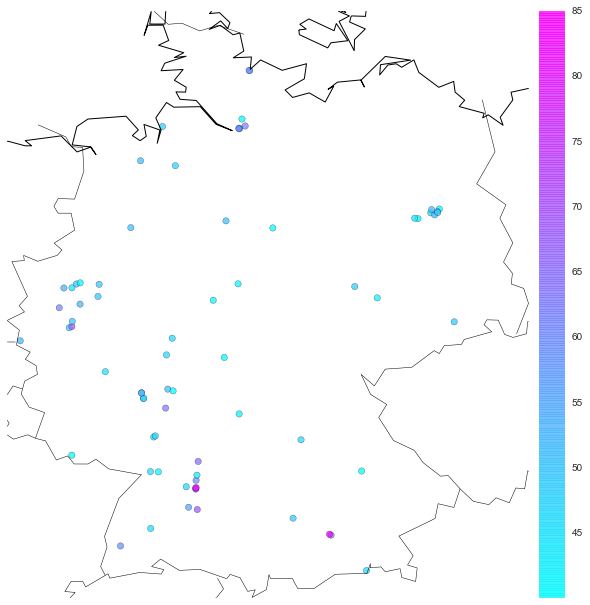

In [17]:
plot_map(stations_exceeding_40, 'value')

Kann man denn vom Mittelwert 2015 schon auf den Gesamtjahresmittelwert schließen? Nein, natürlich nicht. Aber die Tendenz ist, dass die Stickoxide im Winter steigen. Hier die Monatsmittelwerte aller Jahre im Datensatz.

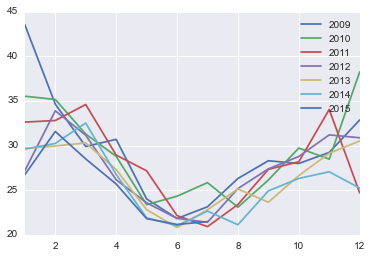

In [18]:
for year, grouped in df.groupby(df.index.year):
    grouped.groupby(grouped.index.month).value.mean().plot(label=year)
plt.legend()

## Stationen 2015 mit mehr als 18 Überschreitungen von Stundenwerten 200 µg/m^3 bis zum 31.7.

Alle diese Stationen haben auch Jahresgrenzwerte von > 40 (Daten bis 31.7.)

In [19]:
greater_200 = df[df.value > 200]
exceeding_200_count = (greater_200.groupby([greater_200.index.year, greater_200.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_200_in_2015 = exceeding_200_count[(exceeding_200_count.jahr == 2015) & (exceeding_200_count.anzahl > 18)]

exceeding_stations_2015 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_stations_2015

,jahr,Station,anzahl,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
0,2015,DEBW118,24,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110
1,2015,DEBY115,19,München/Landshuter Allee,Luftmessstation,NaN,2004-07-01,2004-07-01,NaT,nein,...,1A3,"3,9","4,5",NaN,k.A.,NaN,11.536513,48.149606,521,91620
2,2015,DEHE040,29,Darmstadt-Hügelstraße,Luftmessstation,NaN,1993-11-01,1993-11-01,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.653745,49.869457,158,64110


## Tendenzen der Stationen über die Jahre

Generell geht es runter, im Schnitt -3µg/m^3 zwischen 2009 und 2014. Aber es gibt ~45 Messstationen, die 2014 schlechtere Jahresmittelwerte als 2009 haben.

In [20]:
df_2009 = df[df.index.year == 2009]
df_2014 = df[df.index.year == 2014]
stations_mean_2009 = df_2009.groupby('Station').value.mean()
stations_mean_2014 = df_2014.groupby('Station').value.mean()
stations_difference = stations_mean_2014 - stations_mean_2009
stations_difference.describe()

count    361.000000
mean      -3.828525
std        4.453329
min      -32.223841
25%       -5.316911
50%       -2.937584
75%       -1.043384
max        5.075042
Name: value, dtype: float64

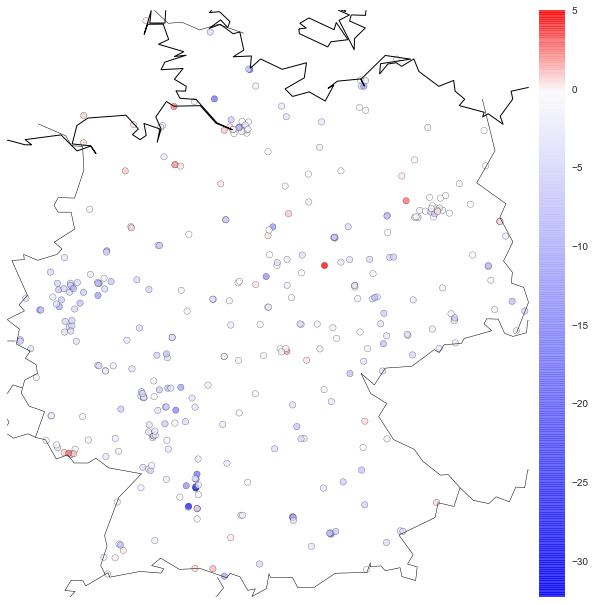

In [21]:
station_diff = stations_difference.reset_index().merge(stations, on="Station")
plot_map(station_diff, 'value', cmap='bwr', diverging=True)

In [22]:
station_diff.sort_index(by='value', ascending=False).head(50)

,Station,value,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
130,DEST095,5.075042,Aschersleben,Luftmessstation,NaN,2000-11-02,2000-11-02,NaT,ja,Hinter dem Zoll,...,1A3,"1,7","2,4",NaN,k.A.,NaN,11.449438,51.759554,125,15089
298,DEBB067,2.931137,Nauen,Luft- und Depositionsmessstation,NaN,2003-08-11,2003-08-11,NaT,NaN,Kreuztaler Str.,...,no,"3,5","3,5","1,5",k.A.,NaN,12.885194,52.608609,31,12063
115,DEBB042,2.849716,"Frankfurt (Oder), 1997-2014",Luftmessstation,FFMA,1997-04-21,1997-04-21,2014-05-05,nein,Markendorfer Str.,...,no,"3,5","3,5","1,5",k.A.,NaN,14.531918,52.339953,58,12053
180,DESL010,2.793254,Saarbrücken-Burbach,Luftmessstation,BURB,1983-07-01,1983-07-01,NaT,nein,Von-der-Heydt-Straße,...,no,"3,5","3,5",NaN,k.A.,NaN,6.948776,49.244247,211,10041
73,DENI059,2.602516,Elbmündung,Luftmessstation,NaN,1998-03-20,1998-03-20,NaT,nein,Wehldorfer Straße,...,no,"3,40","4,70",NaN,k.A.,NaN,8.801220,53.830170,3,33520
435,DEHB001,2.197203,Bremen-Mitte,Luftmessstation,NaN,1987-01-01,1987-01-01,NaT,ja,Präsident-Kennedy-Platz,...,no,"3,5","3,5",NaN,k.A.,NaN,8.815780,53.077151,10,40110
112,DETH040,2.087119,Großer Eisenberg,Luftmessstation,NaN,1994-12-04,1994-12-04,NaT,nein,--,...,no,"3,5",NaN,NaN,k.A.,NaN,10.787135,50.619181,907,16070
6,DERP002,2.062715,Ludwigshafen-Mitte,Luftmessstation,NaN,1978-01-01,1978-01-01,2014-01-15,nein,Neuer Messplatz,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.438589,49.482316,93,73140
239,DEBW038,1.428813,Friedrichshafen,Luftmessstation,NaN,1987-01-01,1987-01-01,NaT,nein,Ehlerstr./Polizeirevier,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.485675,47.660056,404,84350
70,DENI063,1.261382,Altes Land,Luftmessstation,NaN,1999-02-11,1999-02-11,NaT,nein,Ostfeld,...,no,"3,30","4,65",NaN,k.A.,NaN,9.685030,53.524180,3,33590


In [23]:
kreise = pd.read_csv('data/12411-0014.csv', skiprows=5, skipfooter=5, delimiter=';', encoding='latin-1')
kreise.rename(columns={'Unnamed: 0': 'ags', 'Unnamed: 1': 'Kreisname'}, inplace=True)
kreise['ags'] = kreise['ags'].apply(lambda x: '{:0>5d}'.format(x))
kreise = kreise[['ags', 'Kreisname']]
kreise.head()


/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


,ags,Kreisname
0,01001,"Flensburg, kreisfreie Stadt"
1,01002,"Kiel, kreisfreie Stadt"
2,01003,"Lübeck, kreisfreie Stadt"
3,01004,"Neumünster, kreisfreie Stadt"
4,01051,"Dithmarschen, Landkreis"


In [24]:
df_2009_ags = df_2009.merge(stations[['Station', 'ags']], on='Station').groupby('ags').value.mean()
df_2014_ags = df_2014.merge(stations[['Station', 'ags']], on='Station').groupby('ags').value.mean()

df_diff_ags = df_2014_ags - df_2009_ags
df_diff_ags = df_diff_ags.order(ascending=False)
df_diff_ags.describe()

count    224.000000
mean      -3.138674
std        4.649941
min      -21.422409
25%       -5.289598
50%       -2.598710
75%       -0.695285
max       18.016377
Name: value, dtype: float64

## Histogramm von 2009 und 2014

[0, 80, 0, 40]

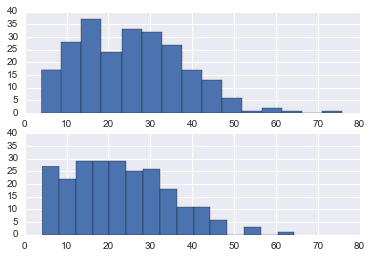

In [25]:
plt.subplot(2, 1, 1)
df_2009_ags.hist(bins=15)
plt.axis([0, 80, 0, 40])
plt.subplot(2, 1, 2)
df_2014_ags.hist(bins=15)
plt.axis([0, 80, 0, 40])

## Kreise, in denen es von 2009 - 2014 schlechter wurde

In [26]:
df_diff_ags_cleaned = df_diff_ags.reset_index()
df_diff_ags_cleaned.ags = (df_diff_ags_cleaned.ags.convert_objects(convert_numeric=True)
                                                  .apply(lambda x: int(x / 10.0))
                                                  .apply(lambda x: '{:05d}'.format(x)))
df_diff_ags_cleaned = df_diff_ags_cleaned.merge(kreise, on='ags')
df_diff_ags_cleaned = df_diff_ags_cleaned.sort_index(by='value', ascending=False)
df_diff_ags_cleaned.head(20)

,ags,value,Kreisname
0,03403,18.016377,"Oldenburg (Oldenburg), kreisfreie Stadt"
1,08121,15.077052,"Heilbronn, kreisfreie Stadt"
2,03103,10.735965,"Wolfsburg, kreisfreie Stadt"
3,08215,7.616578,"Karlsruhe, Landkreis"
4,05513,7.499909,"Gelsenkirchen, kreisfreie Stadt"
5,09663,6.660836,"Würzburg, kreisfreie Stadt"
6,07316,5.178678,"Neustadt an der Weinstraße, kreisfreie Stadt"
7,08226,2.629007,Rhein-Neckar-Kreis
8,03352,2.602516,"Cuxhaven, Landkreis"
9,01061,2.489519,"Steinburg, Landkreis"


In [27]:
import folium

def make_kreise_map(geo_data, key='value', diverging=False, fill='PRGn'):

    # We use the geo json file for our metro we generated above
    # geo_path = r'kreise.geojson'
    geo_path = 'geodata/kreise.topo.json'
    
    geo_data = geo_data.copy()
    geo_data[key] *= -1

    min_val = geo_data[key].min()
    q1 = geo_data[key].quantile( .25)
    q2 = geo_data[key].quantile( .5)
    q3 = geo_data[key].quantile( .75)
    q4 = geo_data[key].quantile( .9)
    max_val = geo_data[key].max()
    scale = None
    if diverging:
        scale = [min_val, min_val / 2, 0, 1, max_val / 2, max_val]
        print(scale)
    else:
        scale = [min_val, q1, q2, q3, q4, max_val]

    m = folium.Map(location=[52, 10], zoom_start=6, height=800)
    m.geo_json(geo_path=geo_path, data=geo_data, data_out='%s_diff.json' % key,
                 columns=['ags', key],
                 threshold_scale=scale,
                 key_on='feature.properties.AGS',
                 fill_color=fill, fill_opacity=0.7, line_opacity=0.3,
                 legend_name='',
                 topojson='objects.kreise', reset=True
    )
    m.create_map(path='map_diff_pp.html')
    return m

### Tendenzen der Kreise

Grün: 2014 mehr als 2009, rosa: weniger, schwarz: unbekannt

In [28]:
make_kreise_map(df_diff_ags_cleaned, diverging=True)

[-18.016377378260103, -9.0081886891300513, 0, 1, 10.711204252485796, 21.422408504971592]


### Durchschnittswerte der Kreise 2015

In [29]:
df_2015_ags = df_2015.merge(stations[['ags', 'Station']], on='Station').groupby('ags').value.mean().reset_index()
df_2015_ags.ags = (df_2015_ags.ags.convert_objects(convert_numeric=True)
                                                  .apply(lambda x: int(x / 10.0))
                                                  .apply(lambda x: '{:05d}'.format(x)))
df_2015_ags = df_2015_ags.merge(kreise, on='ags')
df_2015_ags.sort_index(by='value', ascending=False).head(50)

,ags,value,Kreisname
106,08111,63.717354,"Stuttgart, kreisfreie Stadt"
43,05119,53.925797,"Oberhausen, kreisfreie Stadt"
29,03403,51.409700,"Oldenburg (Oldenburg), kreisfreie Stadt"
62,05914,49.697748,"Hagen, kreisfreie Stadt"
45,05124,48.481517,"Wuppertal, kreisfreie Stadt"
110,08121,47.630184,"Heilbronn, kreisfreie Stadt"
138,09187,46.241445,"Rosenheim, Landkreis"
135,09162,45.614537,"München, kreisfreie Stadt"
125,08325,45.383938,"Rottweil, Landkreis"
72,06414,44.484900,"Wiesbaden, kreisfreie Stadt"


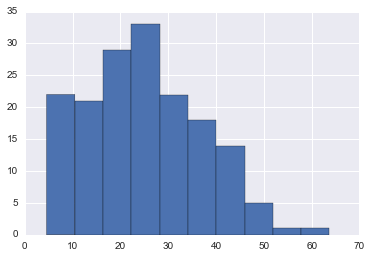

In [30]:
df_2015_ags.value.hist()

In [31]:
make_kreise_map(df_2015_ags, fill='OrRd')

## Schlechteste Durchschnittswerte 2014

In [32]:
df_2014_ags = df_2014.merge(stations[['ags', 'Station']], on='Station').groupby('ags').value.mean().reset_index()
df_2014_ags.ags = (df_2014_ags.ags.convert_objects(convert_numeric=True)
                                                  .apply(lambda x: int(x / 10.0))
                                                  .apply(lambda x: '{:05d}'.format(x)))
df_2014_ags = df_2014_ags.merge(kreise, on='ags')
df_2014_ags.sort_index(by='value', ascending=False).head(50)

,ags,value,Kreisname
106,08111,64.435916,"Stuttgart, kreisfreie Stadt"
43,05119,54.946690,"Oberhausen, kreisfreie Stadt"
29,03403,53.850894,"Oldenburg (Oldenburg), kreisfreie Stadt"
62,05914,53.417531,"Hagen, kreisfreie Stadt"
110,08121,47.629498,"Heilbronn, kreisfreie Stadt"
71,06414,46.146803,"Wiesbaden, kreisfreie Stadt"
63,05916,45.682210,"Herne, kreisfreie Stadt"
109,08118,45.384638,"Ludwigsburg, Landkreis"
135,09162,45.081669,"München, kreisfreie Stadt"
10,01060,44.565346,"Segeberg, Landkreis"


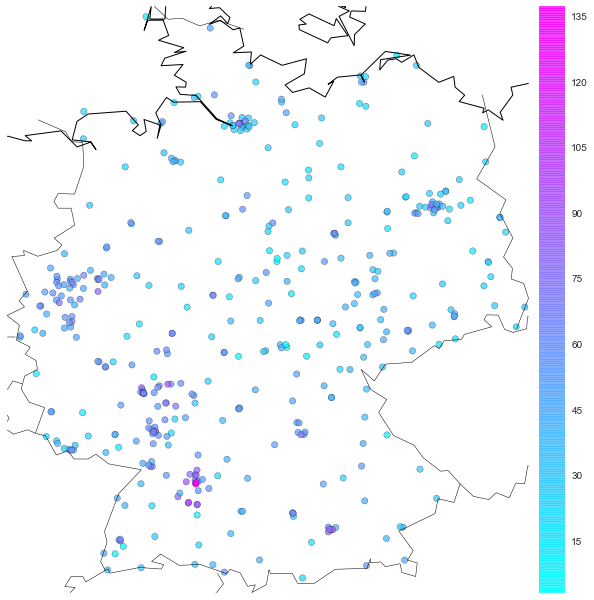

In [34]:
# Work in progress

from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets



grouped = df.groupby(df.Station.astype(str))
grouped = grouped.resample('1M').reset_index()
grouped = grouped.merge(stations[['Station', 'lat', 'lng']], on='Station').set_index('date')


def draw_plot(x):
    return plot_map(grouped.ix[grouped.index[x]], 'value')


time_units = len(grouped.index.unique())

interact(draw_plot, x=widgets.IntSlider(min=0,max=time_units,step=1,value=0));